### Using GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5429946903895560293
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3155650150
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8032741576999008375
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [5]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Image Generation from Audio

In [7]:
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from utils import read_file, transform_path
import soundfile as sf

In [8]:
DATA = Path('C:\\Work\\Job_Applications\\India\\Mindstix\\data')

# these folders must be in place
NSYNTH_AUDIO = DATA/'librispeech_fastai_data'
TRAIN_AUDIO_PATH = NSYNTH_AUDIO/'train'
VALID_AUDIO_PATH = NSYNTH_AUDIO/'valid'

# these folders will be created
NSYNTH_IMAGES = DATA/'librispeech_fastai_data_images'
TRAIN_IMAGE_PATH = NSYNTH_IMAGES/'train'
VALID_IMAGE_PATH = NSYNTH_IMAGES/'valid'

In [9]:
import os
os.getcwd()

'C:\\Work\\Job_Applications\\India\\Mindstix\\speaker_recognition\\notebooks'

In [10]:
train_acoustic_fnames = [f.name for f in TRAIN_AUDIO_PATH.iterdir()]
valid_acoustic_fnames = [f.name for f in VALID_AUDIO_PATH.iterdir()]
len(train_acoustic_fnames), len(valid_acoustic_fnames)

(1146, 607)

In [11]:
fn = train_acoustic_fnames[8]; fn

'14-208-0008.flac'

In [12]:
TRAIN_AUDIO_PATH/fn

WindowsPath('C:/Work/Job_Applications/India/Mindstix/data/librispeech_fastai_data/train/14-208-0008.flac')

In [13]:
data,samplerate=sf.read(str(TRAIN_AUDIO_PATH/fn))
data

array([ 0.002411,  0.002289,  0.002777,  0.002808, ..., -0.001709, -0.001831, -0.001587, -0.00174 ])

In [14]:
Audio(data,rate=samplerate)

In [15]:
x, sr = read_file(fn, TRAIN_AUDIO_PATH)
x.shape, sr, x.dtype

((196640,), 16000, dtype('float32'))

In [16]:
def log_mel_spec_tfm(fname, src_path, dst_path):
    x, sample_rate = read_file(fname, src_path)
    
    n_fft = 1024
    hop_length = 256
    n_mels = 40
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
    dst_fname = dst_path / (fname[:-4] + '.png')
    plt.imsave(dst_fname, mel_spec_db)

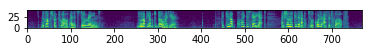

In [17]:
log_mel_spec_tfm(fn, TRAIN_AUDIO_PATH, Path('.'))
img = plt.imread(fn[:-4] + '.png')
plt.imshow(img, origin='lower');

In [18]:
# TRAIN files took 10m43s

from utils import log_mel_spec_tfm

transform_path(TRAIN_AUDIO_PATH, TRAIN_IMAGE_PATH, log_mel_spec_tfm, 
               fnames=train_acoustic_fnames, delete=True)

In [19]:
# VALID files took  0m31s
transform_path(VALID_AUDIO_PATH, VALID_IMAGE_PATH, log_mel_spec_tfm, 
               fnames=valid_acoustic_fnames, delete=True)

In [22]:
import cv2

img_rows=300
img_cols=300

DATA_PATH = "C:\\Work\\Job_Applications\\India\\Mindstix\\data\\librispeech_fastai_data_images\\train"
# DATA_PATH = "C:\\Work\\Job_Applications\\India\\Mindstix\\data\\librispeech_fastai_data_images\\valid"

img_list = os.listdir(DATA_PATH)

for img in img_list:
#     print(img)
    input_img = cv2.imread(DATA_PATH+ '\\' + img)
#     print(input_img.shape)
    input_img_resize = cv2.resize(input_img,(img_rows, img_cols))            
    cv2.imwrite(DATA_PATH+ '\\' + img, input_img_resize)
    

### Transfer learning using resnet architecture

In [21]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Input, Dense
from keras.models import Sequential

In [1]:
num_channel = 3
img_rows=300
img_cols=300

my_new_model = Sequential()
image_input = Input(shape=(img_rows, img_cols, num_channel))

resnet = ResNet50(input_tensor=image_input, include_top=True, weights='imagenet')

# Say not to train first layer (ResNet) model. It is already trained
my_new_model.layers[0].trainable = False

NameError: name 'Sequential' is not defined

In [ ]:
import fastai
fastai.__version__

In [ ]:
from fastai.vision import *

In [23]:
instrument_family_pattern = r'(\d+)-\d+-\d+..png$'

data = (ImageList.from_folder(NSYNTH_IMAGES)
            .split_by_folder()
            .label_from_re(instrument_family_pattern)
            .databunch())
data.c, data.classes

C:\Anaconda3\lib\site-packages\fastai\data_block.py:537: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
27, 32, 39, 19, 26
  if getattr(ds, 'warn', False): warn(ds.warn)


(10, ['14', '16', '17', '22', '23', '28', '30', '38', '54', '55'])

In [24]:
xs, ys = data.one_batch()
xs.shape, ys.shape



(torch.Size([64, 3, 100, 800]), torch.Size([64]))

In [25]:
xs.min(), xs.max(), xs.mean(), xs.std()

(tensor(0.0039), tensor(0.9882), tensor(0.3892), tensor(0.1877))

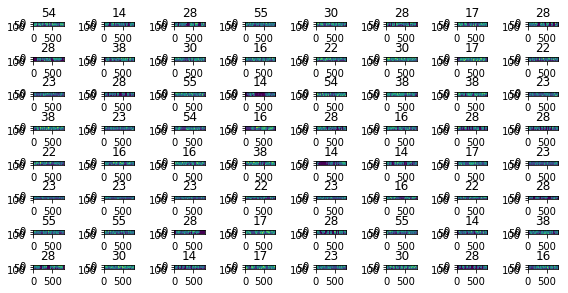

In [26]:
data.show_batch(10, figsize=(8,4), hide_axis=False)

In [27]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.660732,3.040319,0.000000,02:01
1,0.768084,3.326356,0.000000,01:52
2,0.445337,2.939093,0.000000,01:53


In [28]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(10, 10), dpi=60)

In [ ]:
interp.most_confused(min_val=20)